In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
import sys

from disp import set_plot


DX = .01
X_MIN, X_MAX = -50, 50
X = np.linspace(X_MIN, X_MAX, int((X_MAX-X_MIN)/DX)+1)

def norm(x, mu, sgm):
    if sgm == 0:
        temp = np.zeros(X.shape)
        temp[np.argmin(np.abs(X))] = 1/DX
        return temp
    
    return stats.norm.pdf(x, loc=mu, scale=sgm)

def phi(x, mu, sgm):
    if sgm == 0:
        temp = (X >= 0).astype(float)
        temp[X == 0] = .5
        return temp
    
    return stats.norm.cdf(x, loc=mu, scale=sgm)

def lam_2(D, mu, sgm):
    return DX*np.sum(X**2*norm(X, mu, sgm)*phi(X, mu, sgm)**(D-1))

def lam_1(D, mu, sgm):
    return DX*np.sum(X*norm(X, mu, sgm)*phi(X, mu, sgm)**(D-1))

def get_lam_max(D, mu_0, mu_1, sgm_0, sgm_1):
    a = np.sqrt(D)*(mu_0 - mu_1)
    b = np.sqrt(D)*mu_1
    c = sgm_0**2 - sgm_1**2
    d = sgm_1**2
    
    mu_star = a/D + b
    v_star = c/D + d
    
    aa = c/(2*(c/D + d)**2)
    bb = (a*d - b*c)/(c/D + d)**2
    cc = (b**2*c - a**2*c/D**2 - 2*a**2*d/D - 2*a*b*d - c**2/D - c*d)/(2*(c/D + d)**2)
    
    return D/(D-1) * (aa * lam_2(D, mu_star, np.sqrt(v_star)) + bb * lam_1(D, mu_star, np.sqrt(v_star)) + cc/D)

In [2]:
def get_active(ths, t_1):
    ths_mn = ths[t_1:, :].mean(0)  # ppln time average
    matv = ths_mn > np.max(ths_mn/2)  # mask over active labels
    iatv = matv.nonzero()[0]  # idxs of active labels
    return iatv

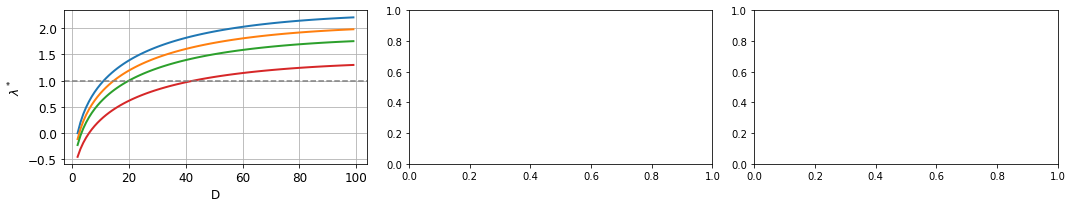

In [3]:
MU_1 = 0
SGM_0 = 1
SGM_1 = 0.05

fig, axs = plt.subplots(1, 3, figsize=(15, 3), tight_layout=True)
MU_0S = [0, -.1, -.2, -.4]
DS = np.arange(1, 100)

for MU_0 in MU_0S:
    lam_maxs = np.array([get_lam_max(D, MU_0, MU_1, SGM_0, SGM_1) for D in DS])
    axs[0].plot(DS, lam_maxs, lw=2)
    
axs[0].axhline(1, color='gray', ls='--')
axs[0].grid()
set_plot(axs[0], x_label='D', y_label=r'$\lambda^*$', font_size=12)

## Varying $\sigma_0/\sigma_1$ and $D$

In [9]:
MU_0S = [0, -.1, 0]
MU_1S = [0, 0, -.1]
SGM_0 = 1

DS = np.arange(1, 41)

DSGM_1 = .01
SGM_1S = np.arange(0, .25+DSGM_1, DSGM_1)

lam_maxs_all = []

for MU_0, MU_1 in zip(MU_0S, MU_1S):
    lam_maxs = np.nan*np.zeros((len(DS), len(SGM_1S)))

    for cd, d in enumerate(DS):
        for csgm_1, SGM_1 in enumerate(SGM_1S):
            lam_maxs[cd, csgm_1] = get_lam_max(d, MU_0, MU_1, SGM_0, SGM_1)
    
    lam_maxs_all.append(lam_maxs.copy())

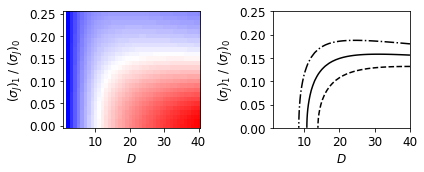

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2.5), tight_layout=True)
axs[0].matshow(lam_maxs_all[0].T, origin='lower', extent=[.5, DS[-1] + .5, -DSGM_1/2, SGM_1S[-1]+DSGM_1/2], cmap='seismic', vmin=-1, vmax=3)
axs[0].set_aspect('auto')

labels = []
lss = ['-', '--', '-.']
for MU_0, MU_1, lam_maxs, ls in zip(MU_0S, MU_1S, lam_maxs_all, lss):
    axs[1].contour(*np.meshgrid(DS, SGM_1S), lam_maxs.T, levels=[1], colors='k', linestyles=ls)
    labels.append('$\mu =$')# + f'{MU_0}')

for ax in axs:
    ax.xaxis.tick_bottom()
    set_plot(ax, x_ticks=[10, 20, 30, 40], x_label=r'$D$', y_label=r'$(\sigma_J)_1 \; / \; (\sigma_J)_0$')
    
fig.savefig('figs/main/4_multi_unif_stability_portrait.svg')